In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

import datetime
from sys import getsizeof,path

import matplotlib.pyplot as plt
import matplotlib

path.append("../src")
from Splines import CentripetalCatmullRomSpline_splitControls,Spline

import pymc3 as pm
import theano
import theano.tensor as tt


theano.config.gcc_cxxflags = "-Wno-c++11-narrowing"

import arviz as az

# Simple Example - recover control Params

(False,)
Test values in 0.545s
(False,)


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 22900
Interrupted at 22,899 [11%]: Average Loss = 222.91
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, est_control, sigma_control]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 53 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Compiled and Sampled in 81.488


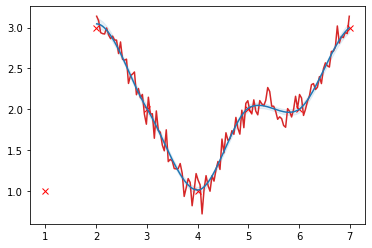

In [3]:
old = False

coords = {"cpx":np.array([1,2,3,4,5,6,7],"float64"),"space":np.linspace(2.01,6.99,128,"float64")}
test_control = np.array([1,3,2,1,2,2,3],"float64")
test_spline = Spline(coords["cpx"],tt.cast(test_control,"float64"))

t1 = time.time()
test_values = test_spline.EvaluateAt(coords["space"],old=old).eval()
test_values += np.random.normal(0, .1, coords["space"].shape[0])
t2 = time.time()
print("Test values in %.3fs"%(t2-t1))

plt.plot(coords["space"],test_values,color="tab:red")
plt.plot(coords["cpx"],test_control,"rx")

with pm.Model(coords=coords) as model:
    
    sigma_control = pm.Lognormal("sigma_control",mu=tt.log(2),sigma=1.)
    
    est_control = pm.Normal("est_control",mu=0,sigma=sigma_control,dims=("cpx"))
    est_control = tt.exp(tt.cumsum(est_control))
    
    est_spline = Spline(coords["cpx"],est_control)
    est_values = est_spline.EvaluateAt(coords["space"],old=old)
    
    pm.Deterministic("est_values",est_values)

    sigma_obs = pm.HalfCauchy(name="sigma_obs",beta=2)
    pm.StudentT("est",nu=4,sigma=tt.abs_(est_values+1.)**.5 * sigma_obs,mu=est_values,observed=test_values)
    
    trace = pm.sample(init="advi",return_inferencedata=True,tune=200,draws=200,cores=4,chains=4,max_treedepth=12,target_accept=.95)

t3 = time.time()
print("Compiled and Sampled in %.3f"%(t3-t2))

q = trace.posterior["est_values"].quantile((0.5,.05,.95),["chain","draw"])
plt.plot(coords["space"],q[0],color="tab:blue")
plt.fill_between(coords["space"],q[1],q[2],alpha=.1,color="tab:blue")

array([[<AxesSubplot:title={'center':'est_control'}>,
        <AxesSubplot:title={'center':'est_control'}>]], dtype=object)

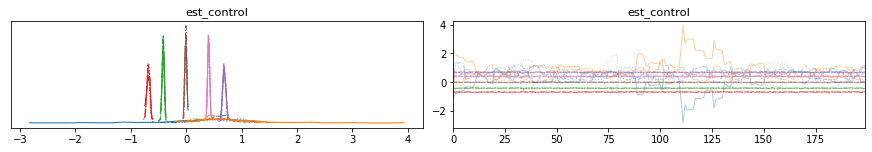

In [4]:
az.plot_trace(trace.posterior["est_control"])

array([[<AxesSubplot:title={'center':'sigma_control'}>,
        <AxesSubplot:title={'center':'sigma_control'}>]], dtype=object)

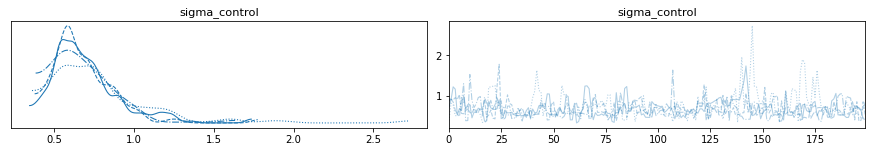

In [14]:
az.plot_trace(trace.posterior["sigma_control"])

array([[<AxesSubplot:title={'center':'sigma_obs'}>,
        <AxesSubplot:title={'center':'sigma_obs'}>]], dtype=object)

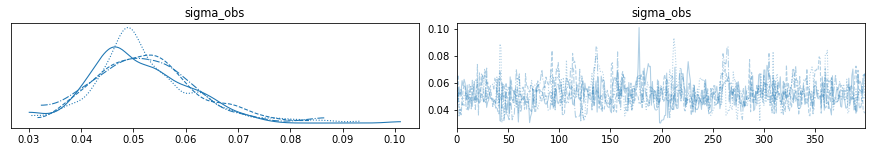

In [6]:
az.plot_trace(trace.posterior["sigma_obs"])

# SEIR Model with R_eff from Spline

In [11]:
coords = {}
if False:
    coords["cpx"] = np.linspace(0,70,8,"float64")
    coords["space"] = np.linspace(8,51,44,"float64")
else:
    coords["cpx"] = pd.date_range(datetime.date(2020,1,30),datetime.date(2020,5,16),freq="SM")
    coords["space"] = pd.date_range(datetime.date(2020,2,20),datetime.date(2020,4,5),freq="D")

print(coords["cpx"],len(coords["cpx"]))
print(coords["space"],len(coords["space"]))

rtest_control = np.array([3,5,6,2,.9,.9,1.1,1.2],"float64")
rtest_spline = Spline(coords["cpx"],tt.cast(rtest_control,"float64"))


t1 = time.time()
rtest_tvalues = rtest_spline.EvaluateAt(coords["space"])
rtest_values = rtest_tvalues.eval()
rtest_values += np.random.normal(0, .1, coords["space"].shape[0])
t2 = time.time()
print("Test values in %.3fs"%(t2-t1))

print(rtest_values)

DatetimeIndex(['2020-01-31', '2020-02-15', '2020-02-29', '2020-03-15',
               '2020-03-31', '2020-04-15', '2020-04-30', '2020-05-15'],
              dtype='datetime64[ns]', freq='SM-15') 8
DatetimeIndex(['2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23',
               '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27',
               '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02',
               '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06',
               '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
               '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
               '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
               '2020-0

/Users/matthiaslinden/HiDrive/users/matthiaslinden/WorkInProgress/CoronaBranches/COVID19_AgeStratifiedModel/BuildingBlocks/../src/Splines.py:193: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  space = space.astype(int).to_numpy()/(1000000000.*60*60*24)
/Users/matthiaslinden/HiDrive/users/matthiaslinden/WorkInProgress/CoronaBranches/COVID19_AgeStratifiedModel/BuildingBlocks/../src/Splines.py:194: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  


Test values in 0.570s
[5.45304677 5.69276013 5.84915389 6.08786896 6.09438741 6.04582929
 6.06823931 6.16674723 6.18939217 6.06092335 5.66296402 5.86553105
 5.4415988  5.3689498  4.93881051 4.66507003 4.36763201 3.96340002
 3.68221816 3.05617355 2.94236776 2.66082939 2.47183613 2.31817744
 2.02589739 1.70034362 1.69984721 1.68674574 1.51267972 1.50120825
 1.44302362 1.24870488 1.19909209 1.07535606 1.09576062 1.08921225
 1.01518639 1.08924386 0.94661784 1.09927324 0.81558906 0.79953209
 0.72952492 0.80409653 1.02972819 0.89685918]


In [12]:
def tt_lognormal(x, mu, sigma):
# Limit to prevent NANs
    x = tt.clip(x,1e-9,1e12)
    sigma = tt.clip(sigma,1e-9,1e12)
    mu = tt.clip(mu,1e-9,1e12)
    
    distr = 1/x * tt.exp( -( (tt.log(x) - mu) ** 2) / (2 * sigma ** 2))
    return distr / (tt.sum(distr, axis=0) + 1e-12)

def SEIR_model(N, imported_t,Reff_t, median_incubation,sigma_incubation,l=32):
    N = tt.cast(N,'float64')
    beta = tt_lognormal(tt.arange(l), tt.log(median_incubation), sigma_incubation)
    
    # Dirty hack to prevent nan - seems not needed if priors are better
 #   beta = tt.alloc(0,l)
  #  beta = tt.set_subtensor(beta[tt.clip(tt.cast(median_incubation,'int32'),1,l-2)],1)
     
    Reff_t = tt.as_tensor_variable(Reff_t)
    imported_t = tt.as_tensor_variable(imported_t)

    def new_day(Reff_at_t,imported_at_t,infected,E_t,beta,N):
        f = E_t / N
     #   f = 1
        new = imported_at_t + tt.dot(infected,beta) * Reff_at_t * f
        new = tt.clip(new,0,N)
     
        infected = tt.roll(infected,1,0)
        infected = tt.set_subtensor(infected[:1],new,inplace=False)
        E_t = tt.clip(E_t-new,0,E_t)
#        E_t = E_t-new
        return new,infected,E_t
    
    outputs_info = [None,np.zeros(l),N]
    infected_t,updates = theano.scan(fn=new_day,
                                     sequences=[Reff_t,imported_t],
                                     outputs_info=outputs_info,
                                     non_sequences=[beta,N],
                                     profile=False)
                                     
    return infected_t

[5.45304677 5.69276013 5.84915389 6.08786896 6.09438741 6.04582929
 6.06823931 6.16674723 6.18939217 6.06092335 5.66296402 5.86553105
 5.4415988  5.3689498  4.93881051 4.66507003 4.36763201 3.96340002
 3.68221816 3.05617355 2.94236776 2.66082939 2.47183613 2.31817744
 2.02589739 1.70034362 1.69984721 1.68674574 1.51267972 1.50120825
 1.44302362 1.24870488 1.19909209 1.07535606 1.09576062 1.08921225
 1.01518639 1.08924386 0.94661784 1.09927324 0.81558906 0.79953209
 0.72952492 0.80409653 1.02972819 0.89685918]
[  6.50161561   6.21130268   4.07486227   2.43169915   1.76797123
   6.17948542  13.90531085  19.93265297  22.56047367  21.20615541
  21.47539436  32.81525151  47.77207265  67.46193415  79.51975684
  86.94323067  96.38708184 111.09100596 137.45334782 149.95959753
 180.30647544 193.95473285 209.34487478 227.95853807 230.97078321
 223.85360083 255.70458728 285.13745275 282.87748786 303.13293894
 307.62044395 280.64067292 286.18067568 272.74839817 293.87479777
 305.67527632 291.38171

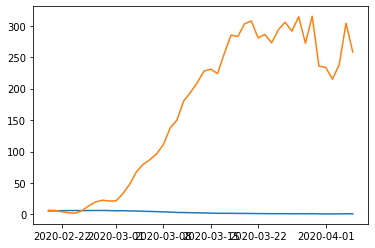

In [13]:
initial = tt.zeros_like(rtest_tvalues)
initial = tt.set_subtensor(initial[:5],tt.cast([6,6,4,2,1],"float64"))

new,infected,E_t = SEIR_model(83e8,initial,rtest_values,6,.3)

new_infected = new.eval()
new_infected += np.random.normal(0, .3, coords["space"].shape[0])

print(rtest_values)
print(new_infected)

plt.plot(coords["space"],rtest_values)
plt.plot(coords["space"],new_infected)

In [ ]:
old = True
t2 = time.time()

with pm.Model(coords=coords) as model:
    
    sigma_control = pm.Lognormal("sigma_control",mu=tt.log(2),sigma=1.)
    
    est_control = pm.Normal("est_control",mu=0,sigma=sigma_control,dims=("cpx"))
    est_control = tt.exp(tt.cumsum(est_control))
    
    est_spline = Spline(coords["cpx"],est_control)
    est_values = est_spline.EvaluateAt(coords["space"],old=old)
    
    est_new,est_infected,est_E_t = SEIR_model(83e8,initial,est_values,6,.3)
    
    pm.Deterministic("est_control_sum",est_control)
    pm.Deterministic("est_values",est_values)
    pm.Deterministic("est_new",est_new)

    sigma_obs = pm.HalfCauchy(name="sigma_obs",beta=2)
    pm.StudentT("est",nu=4,sigma=tt.abs_(est_new+1.)**.5 * sigma_obs,mu=est_new,observed=new_infected)
    
    trace = pm.sample(init="advi",return_inferencedata=True,tune=200,draws=200,cores=4,chains=4,max_treedepth=12,target_accept=.95)

t3 = time.time()
print("Compiled and Sampled in %.3f"%(t3-t2))

(False,)


/Users/matthiaslinden/HiDrive/users/matthiaslinden/WorkInProgress/CoronaBranches/COVID19_AgeStratifiedModel/BuildingBlocks/../src/Splines.py:193: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  space = space.astype(int).to_numpy()/(1000000000.*60*60*24)
/Users/matthiaslinden/HiDrive/users/matthiaslinden/WorkInProgress/CoronaBranches/COVID19_AgeStratifiedModel/BuildingBlocks/../src/Splines.py:194: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 30900
Interrupted at 30,899 [15%]: Average Loss = 365.73
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, est_control, sigma_control]


<xarray.DataArray 'est_control_sum' (quantile: 3, est_control_sum_dim_0: 8)>
array([[2.24396946, 4.76369688, 6.05237218, 2.0156645 , 0.81561943,
        0.85831279, 0.77298279, 0.79934968],
       [0.63065904, 3.77587362, 5.81697127, 1.96285494, 0.78102415,
        0.81473614, 0.1665565 , 0.07212646],
       [7.68560195, 5.79335325, 6.28164826, 2.07080659, 0.85041737,
        0.91376044, 2.04115803, 5.609503  ]])
Coordinates:
  * est_control_sum_dim_0  (est_control_sum_dim_0) int64 0 1 2 3 4 5 6 7
  * quantile               (quantile) float64 0.5 0.05 0.95


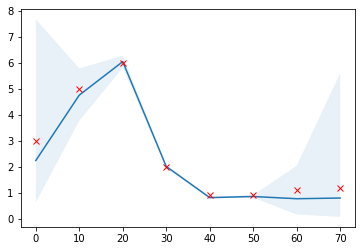

In [72]:
q = trace.posterior["est_control_sum"].quantile((0.5,.05,.95),["chain","draw"])

plt.plot(coords["cpx"],q[0])
plt.fill_between(coords["cpx"],q[1],q[2],alpha=.1)

print(q)
plt.plot(coords["cpx"],rtest_control,"rx")

array([[<AxesSubplot:title={'center':'est_control'}>,
        <AxesSubplot:title={'center':'est_control'}>]], dtype=object)

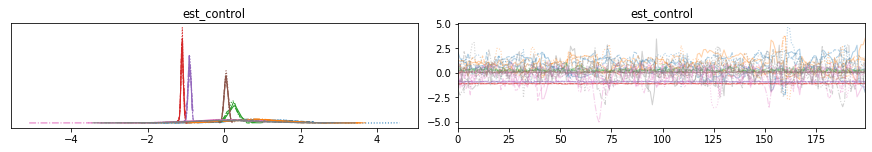

In [73]:
az.plot_trace(trace.posterior["est_control"])

<xarray.DataArray 'est_new' (quantile: 3, est_new_dim_0: 44)>
array([[  6.        ,   6.        ,   4.00000068,   2.02412154,
          1.97392061,   5.29825896,  12.53421125,  18.76734579,
         21.05105461,  20.59984586,  22.34426948,  31.72951804,
         49.44738402,  69.35233623,  84.2492807 ,  93.22087488,
        101.97636499, 117.31872563, 139.22599833, 160.54791674,
        173.66615275, 177.88748964, 179.4336675 , 183.516054  ,
        188.24818251, 191.98906549, 192.50927052, 189.21021195,
        183.40779888, 176.6025858 , 169.55579065, 162.12431564,
        153.22978006, 144.65790014, 138.1888166 , 134.0150631 ,
        131.63634238, 129.92841097, 128.26129898, 126.43541735,
        124.16119777, 121.55365567, 118.34953357, 114.80511648],
       [  6.        ,   6.        ,   4.00000054,   2.019782  ,
          1.82503446,   4.63512042,  11.36847321,  17.54324181,
         20.21018079,  20.02206452,  21.4669347 ,  30.04498356,
         47.12610752,  67.24766238,  82.4

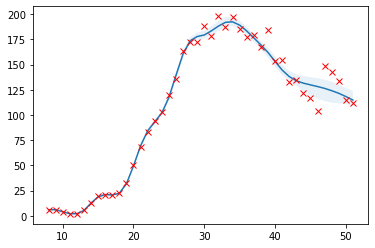

In [74]:
q = trace.posterior["est_new"].quantile((0.5,.05,.95),["chain","draw"])

plt.plot(coords["space"],q[0])
plt.fill_between(coords["space"],q[1],q[2],alpha=.1)

print(q)
plt.plot(coords["space"],new_infected,"rx")

array([[<AxesSubplot:title={'center':'sigma_control'}>,
        <AxesSubplot:title={'center':'sigma_control'}>]], dtype=object)

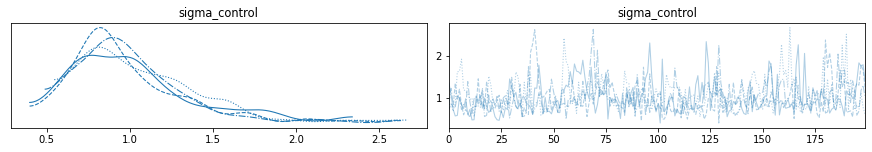

In [75]:
az.plot_trace(trace.posterior["sigma_control"])

array([[<AxesSubplot:title={'center':'sigma_obs'}>,
        <AxesSubplot:title={'center':'sigma_obs'}>]], dtype=object)

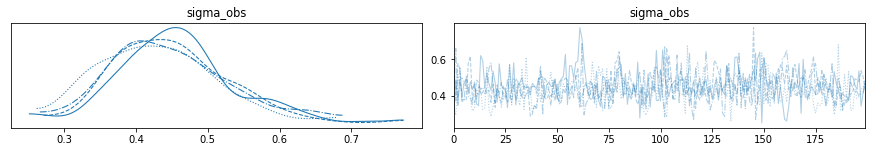

In [76]:
az.plot_trace(trace.posterior["sigma_obs"])

# Hierachical SurvStat
Run Age,location stratified SEIR and compare with weekly reporting from SurvStat

- seasonality (12 monthly values) --> global R_0
- per week: walk representing gradual change in measures
- per BL: monthly diff (measures might be fast)
- per AG: monthly diff

100 weeks * 16 BL * 5 AG = 8k weekly values, 56k entries in R_eff-matrix (daily)

In [ ]:
# Unfortunately not feasable even with HalfCauchy instead of Lognormal for the hyperparameter.
4-10x more time spend outside of sampling, than inside if number of days surpasses ~100 days. ~1h pre+post 

In [11]:
t0 = time.time()

start = datetime.datetime(2020,3,15)
end = datetime.datetime(2020,6,1)

coords = {}

coords["seasons_12month"] = range(1,13)
coords["days"] = pd.date_range(start,end,freq="D")
coords["weeks"] = pd.date_range(start,end,freq="W")
coords["months"] = pd.date_range(start,end,freq="M")
coords["BL"] = range(1,17)
coords["AG"] = np.array([0,20,40,60,80])

print(len(coords["days"]))

with pm.Model(coords=coords) as model:

    # Seasonality
    season_sigma = pm.HalfCauchy("season_sigma",beta=1.)
    season_control = pm.Lognormal("season_control",mu=tt.log(1.),sigma=season_sigma,dims=("seasons_12month"))
    season_control24m = tt.concatenate([season_control,season_control]).reshape((1,24,))
    season_range24m = pd.date_range(start=datetime.datetime(2020,1,1),end=datetime.datetime(2022,1,1),freq="M")
    season_spline = Spline(season_range24m,season_control24m)
    
    season_daily = season_spline.EvaluateAt(coords["days"])[:,0]
    
    # weekly walk
    measures_sigma = pm.HalfCauchy("measures_sigma",beta=1.)
    measures_value = pm.Normal("measures_value",mu=0.,sigma=measures_sigma,dims=("weeks"))
    measures_walk = tt.cumsum(measures_value,axis=0).reshape((1,len(coords["weeks"]),))
    measures_spline = Spline(coords["weeks"],measures_walk)
    
    measures_daily = measures_spline.EvaluateAt(coords["days"])[:,0]
    pm.Deterministic("measures_daily",measures_daily)
    
    # Monthly Age-Diff
    if True:
        age_sigma = pm.HalfCauchy("age_sigma",beta=1.)
        age_value = pm.Normal("age_value",mu=0.,sigma=age_sigma,dims=("AG","months",))
        age_walk = tt.cumsum(age_value,axis=1)
        age_spline = Spline(coords["months"],age_walk)
    
        age_daily = age_spline.EvaluateAt(coords["days"])#.dimshuffle(1,0)
    else:
        age_daily = tt.cast(0.,"float64").reshape((1,))
    pm.Deterministic("age_daily",age_daily)
    
    # Monthly BL-Diff 
    if True:
        BL_sigma = pm.HalfCauchy("BL_sigma",beta=1.)
        BL_value = pm.Normal("BL_value",mu=0.,sigma=BL_sigma,dims=("BL","months",))
        BL_walk = tt.cumsum(BL_value,axis=1)
        BL_spline = Spline(coords["months"],BL_walk)
        BL_daily = BL_spline.EvaluateAt(coords["days"]).dimshuffle(0,'x',1)
    else:
        BL_daily = tt.cast(0,"float64")
    pm.Deterministic("BL_daily",BL_daily)
    
    modsum = measures_daily.dimshuffle(0,'x','x')+age_daily.dimshuffle(0,1,'x')+BL_daily
    R_eff = season_daily.reshape((len(coords["days"]),1,1,))*tt.exp(modsum)
    pm.Deterministic("R_eff",R_eff)
    
    # Initial Cases
    initial_length = 14
    initial_mag = pm.Lognormal("initial",mu=tt.log(10.),sigma=1.,dims=("AG","BL"))
    initial = tt.zeros_like(R_eff)
    imported = tt.set_subtensor(initial[:initial_length],tt.stack([initial_mag]*initial_length))
    
    
    pm.Deterministic("imported",imported)
    # Dimensions = time x age x BL
  #  pm.Deterministic("sum",measures_daily+age_daily+BL_daily)
    
    t1 = time.time()
    print("parsing %.2f"%(t1-t0))
    #+adapt_diag
    trace = pm.sample(init="advi+adapt_diag",return_inferencedata=True,tune=200,draws=200,cores=8,chains=8,max_treedepth=12,target_accept=.95)
    t2 = time.time()
    print("toal %.1fs"%(t2-t1))

# advi 3.97, 103 total, season+measures
# advi+adapt_diag 1.62, 107.8 total, seaoson+measures
# advi 3.75, 51s sampling 166s total, season+measures+age
# advi 1.92, 51s sampling 166s total, season+measures+age
# BL as single Catmull 66.1

79
parsing 2.52


Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 13000
Interrupted at 12,999 [6%]: Average Loss = 17.096
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [initial, BL_value, BL_sigma, age_value, age_sigma, measures_value, measures_sigma, season_control, season_sigma]


Sampling 8 chains for 200 tune and 200 draw iterations (1_600 + 1_600 draws total) took 242 seconds.
The acceptance probability does not match the target. It is 0.857788905943103, but should be close to 0.95. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 7.33358159144709e-77, but should be close to 0.95. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9037747922998371, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7311776206872815, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance pro

toal 584.1s


array([[<AxesSubplot:title={'center':'season_sigma'}>,
        <AxesSubplot:title={'center':'season_sigma'}>]], dtype=object)

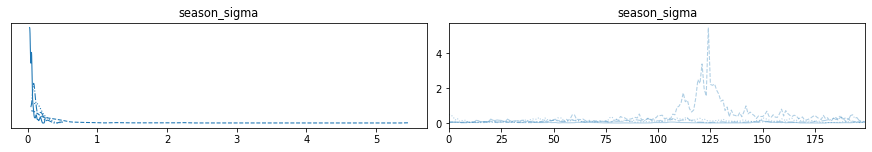

In [12]:
az.plot_trace(trace.posterior["season_sigma"])

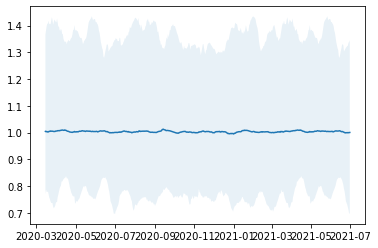

In [13]:
q = trace.posterior["season_daily"].quantile((0.5,.05,.95),["chain","draw"])

plt.plot(coords["days"],q[0])
plt.fill_between(coords["days"],q[1],q[2],alpha=.1)

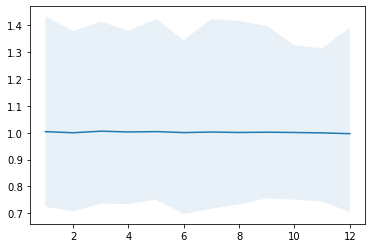

In [16]:
q = trace.posterior["season_control"].quantile((0.5,.05,.95),["chain","draw"])

plt.plot(coords["seasons_12month"],q[0])
plt.fill_between(coords["seasons_12month"],q[1],q[2],alpha=.1)

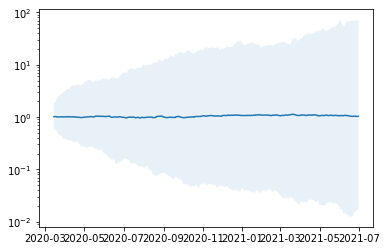

In [30]:
q = trace.posterior["global_R_eff"].quantile((0.5,.05,.95),["chain","draw"])

plt.semilogy(coords["days"],q[0])
plt.fill_between(coords["days"],q[1],q[2],alpha=.1)